<a href="https://colab.research.google.com/github/supurazako/ml-security-jp/blob/master/ch02/Chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

(for my information)

## 夏休みの宿題

L1: 練習問題を動かす

L2: ノートを完成させる

L3: Scikit-learnのドキュメントを読んでみる(今回使ったやつが何しているのか)

## フィッシングサイト

- 正規のサイトを偽装するサイト。例えば `goog"I"e.com` や様々なものがある
- null終端のバグを使ってサイトを詐称するケースなどがあった
  - これは少し違うケースだが、null byteを使っている証明書に関連したCVEなど、null byteに関わる脆弱性は多い
    - 参照: https://nvd.nist.gov/vuln/detail/CVE-2009-2510

##ロジスティック回帰を使用したフィッシング検出器

## ロジスティック回帰とは

ロジスティック回帰は、二項分類を行うためによく使われる、手法である。
後述する決定木を用いた手法よりも昔からある。機械学習の歴史では、割と古めらしい。

## データセットについて

UCI Machine Learning Repositoryのフィッシングサイトのデータセットを使用している。(https://archive.ics.uci.edu/ml/datasets/Phishing+Websites)

このデータセットはarff形式である。arff形式は、昔はデータサイエンスでよく使われていた。Pythonなどを用いた最近のデータサイエンスではあまり使われない。

今回は、用意してある csv形式のデータを使わせていただく。

In [ ]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv

--2025-07-15 09:06:34--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv [following]
--2025-07-15 09:06:34--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 788720 (770K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 770.23K  --.-KB/s    in 0.04s   

2025-07-15 09:06:34 (20.6 MB/s) - ‘dataset.csv’ saved [788720/788720]



In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.0 MB/s eta 0:00:00


## メモ

sklearn -> scikit learn,
ML用のモジュール(なんでもいり,でっかい)

https://scikit-learn.org/stable/

## 2値分類

- 2つの領域に分ける
- true/falseの判定をする

今回でいうと、スパムメールで {ある/ない} などの判定を行う



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

training_data = np.genfromtxt('dataset.csv', delimiter=',', dtype=np.int32)

このまますべてのデータを学習させると、テスト用のデータがなくなってしまう。
学習モデルを評価するには、未知のデータが必要だからだ。

なので、ここでは学習用に0.2(2割)を割り当てている。
このようなデータセットを学習用と評価用に分割し、学習モデルの性能を評価する方法を **ホールドアウト検証** (Hold-out Validatoin)と呼ぶ。

In [ ]:
X = training_data[:,:-1]
y = training_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=101)

classifier = LogisticRegression(solver='lbfgs')

# 訓練用データを使って検出器を訓練する。
classifier.fit(X_train, y_train)
# 予測させる。
predictions = classifier.predict(X_test)

# このフィッシング検出器の正解率を出力させる。
accuracy = 100.0 * accuracy_score(y_test, predictions)
print("The accuracy of your Logistic Regression on testing data is: {}".format(accuracy))

The accuracy of your Logistic Regression on testing data is: 92.17548620533695


## 交差検証

データを分割し、一部分を学習に使い、残りでテストを行う。←これを分割数の数だけやる

ホールドアウト検証と違う点は、3分割以上するという点にある。これにより、どの部分を学習すると一番精度が高いかを検証することが可能になる

今回は5分割でやる

In [ ]:
from sklearn.model_selection import cross_val_score

# 交差検証(5分割)による汎化性能の評価
scores = cross_val_score(classifier, X_train, y_train, cv=5)
# 評価結果の出力
print("Evaluated score by cross-validation(k=5): {}".format(100 * scores.mean()))

Evaluated score by cross-validation(k=5): 92.8766156199402


## ハイパーパラメータとは

ここまでは、データの並び替えはほぼやっていない。データ項目の中でどれが一番効いてくるかは、これまでは経験と勘でやっていた。どの順番で見ると精度が一番上がるかな〜と考えるのがハイパーパラメータチューニングというもの。

このパラメータは、機械学習モデルの"外側"から調整する。ゆえに、"ハイパー"パラメータである。

ハイパーパラメータチューニングには、主に「手動で調整する」と「チューニングツールを使用する」という2つの方法がある。手動で調整するのは、速いが経験や勘などが必要で、属人性が高くなってしまう。

チューニングツールには、scikit-learnのGridSearchCVがある。しかし、この方法は総当たりなので、効率が悪め。そのため、今回はPreferred Newworksのoptunaを使用する。

備考: 今回は時間の節約のため、3つのパラメータに絞って探索を行っている

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            # 最適化に使用するアルゴリズムの候補をカテゴリとして指定
            'solver' : trial.suggest_categorical('solver',\
                    ['newton-cg', 'lbfgs', \
                    'liblinear', 'sag', 'saga']),
            # 正則化の強さに0.0001から10までを指定
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # ソルバーが収束するまでの最大反復回数
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

# ハイパーパラメータの探索
objective = Objective(X_train, y_train)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60)
# ベストのパラメータの出力
print('params:', study.best_params)

[I 2025-07-15 09:33:21,508] A new study created in memory with name: no-name-598dcb3a-2b0b-4022-bcf0-2410958182db
/tmp/ipython-input-8-1163332018.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.0001, 10),
[I 2025-07-15 09:33:23,753] Trial 0 finished with value: 0.9288792144243878 and parameters: {'solver': 'newton-cg', 'C': 0.8499863977671922, 'max_iter': 30204}. Best is trial 0 with value: 0.9288792144243878.
/tmp/ipython-input-8-1163332018.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.0001, 10),
[I 2025-07-15 09:33:24,192] Trial 1 finished with value: 0.9286530979744161 and parameter

params: {'solver': 'newton-cg', 'C': 0.09297420667712418, 'max_iter': 63018}


memo: ベイズ統計というものがある

## ベイズ統計

### ベイズ統計とは

ベイズ統計ベイズの定理を基にした統計学の考え方。新しいデータを取り込みながら推定や予測の精度を高めていくという特徴がある。

### ベイズの定理の活用例

迷惑メールの本文に「無料」という表記があったら迷惑メールなのか?

> 迷惑メールの合計は100通の20%で20通、うち30%で無料表記があるので重なり部分は6通。全メールで「無料」表記がある割合は10%（10通）で、うち迷惑メールの6通を除いた4通が通常メールで本文中に「無料」表記あり。迷惑メールではなく、かつ本部中に「無料」表記もないメールは76通。

> 迷惑メールのうち本文中に「無料」表記がある割合は30%でしたが、同じデータでも見方を変えると、「無料」表記があるメールのうち迷惑メールである割合は60%となります。重なりの部分（6通）を、迷惑メール側から評価するか、「無料」表記あり側から評価するかの違いです。
「ベイズの定理」とは、このベン図の重なりの部分の関係を数式で表したもので、当たり前のことを言っているだけで難しくはありません。見方を変えるという点が「ベイズの定理」のポイントで、データを解釈する際の誤解を排除することができます。同じデータを用いても、違う視点から見ることで、結果に及ぼす要因を正しく評価できます。

このようにデータが増えたときに、それによって既存のデータがどのように変わるかを分析し、精度を高めることができる。これがベイズ統計だ！


参考: https://www.nri.com/jp/knowledge/glossary/bayesian_statistics.html

## 混同行列

|||予測結果||
|-|-|-|-|
|||陰性|陽性|
|正解データ|陰性|真陰性(TN)|偽陽性(FP)|
||陽性|偽陰性(FN)|真陽性(TP)|

端的に言えば上の表のことだ。少し解説すると

- 真陽性(TP): フィッシングサイトをフィッシングサイトであると正しく検出できている数
- 偽陰性(FN): フィッシングサイトを見逃してしまった数
- 真陰性(TN): 非フィッシングサイトを正しく検出できた数
- 偽陽性(FP): 非フィッシングサイトをフィッシングサイトと誤検知した数

という意味だ。

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

model = LogisticRegression(
    # ハイパーパラメータ探索で特定した値を設定
    solver = study.best_params['solver'],
    C = study.best_params['C'],
    max_iter = study.best_params['max_iter']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 92.35640 %
[[ 874   97]
 [  72 1168]]


In [ ]:
from sklearn.metrics import precision_score, recall_score

# 適合率の確認
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred)))
# 再現率の確認
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))

Precision: 92.33202 %
Recall: 94.19355 %


##決定木を使用したフィッシング検出器

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective_DTC:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            'criterion':\
            trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'splitter':\
            trial.suggest_categorical('splitter', ['best', 'random']),
            'max_features':\
            trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'min_samples_split':\
            trial.suggest_int('min_samples_split', 2, 64),
            'max_depth':\
            trial.suggest_int('max_depth', 2, 64)
            }

        model = DecisionTreeClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study(direction='maximize')
# timeoutに60を指定し、最大で1分間探索させる
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2025-07-15 09:55:21,897] A new study created in memory with name: no-name-4a42ef50-8ce5-4f82-9651-0aff872bc6a2
[I 2025-07-15 09:55:22,108] Trial 0 finished with value: 0.9211886332999957 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'log2', 'min_samples_split': 6, 'max_depth': 14}. Best is trial 0 with value: 0.9211886332999957.
[I 2025-07-15 09:55:22,269] Trial 1 finished with value: 0.9250359381914265 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 'log2', 'min_samples_split': 16, 'max_depth': 44}. Best is trial 1 with value: 0.9250359381914265.
[I 2025-07-15 09:55:22,478] Trial 2 finished with value: 0.9137281972840448 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'sqrt', 'min_samples_split': 40, 'max_depth': 35}. Best is trial 1 with value: 0.9250359381914265.
[I 2025-07-15 09:55:22,662] Trial 3 finished with value: 0.9077343208449185 and parameters: {'criterion': 'gini', 'splitter': 'ran

params: {'criterion': 'gini', 'splitter': 'best', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 52}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = DecisionTreeClassifier(
    # ハイパーパラメータ探索で特定した値を設定
    criterion = study.best_params['criterion'],
    splitter = study.best_params['splitter'],
    max_features = study.best_params['max_features'],
    min_samples_split = study.best_params['min_samples_split'],
    max_depth = study.best_params['max_depth']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 適合率の出力
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred,)))
# 再現率の出力
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 95.79376 %
Precision: 96.21273 %
Recall: 96.29032 %
[[ 924   47]
 [  46 1194]]


### tf-idfを使った迷惑メール検出

## NLP

ここからは、実際にメールの文などから迷惑メールを検出する。このデータは前処理が終わっていないので、前処理をする必要がある。そこでNLPが必要というわけだ。

NLP(Natural Language Processing)とは、自然言語を機械で分析して理解する技術のこと。最近では、ChatGPTなど対話型生成AIで使われていることなどから聞く機会も多いと思う。

NLPは、以下の2つの分野があるよ

- NLU(Natural Language Understanding)
  - 入力を有意義な表現に結びつけること。
- NLG(Natural Language Genration)
  - 文章の要約、商品の紹介文、小説などの文章を生成すること。

memo:
日本語など空白で単語が区切られないタイプの言語では、エヌグラムという手法で単語を抽出する方法がある
  
## tf-idfとは

> Term Frequency - Inverse Document Frequencyの略で自然言語をベクトルで表現する方法のひとつであり、ある文書を特徴づける重要な単語を抽出したいときに有効な手法です。

引用元: https://www.takapy.work/entry/2019/01/14/141423

## 自然言語処理の手順

字句分析->構文分析->意味分析->談話統合->語用論的分析

## 勾配ブースティング木

勾配ブースティングとは、ブースティングアルゴリズムのひとつのこと。ブースティングとは、集団学習のフレームワークのひとつであり、複数の弱学習器(単独で使うには精度の低い学習器のこと)を統合して全体の学習器を構成する手法(アンサンブル学習)をとる。勾配ブースティング木では、この弱学習器に決定木を活用している。

In [1]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip

--2025-07-22 09:26:40--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip [following]
--2025-07-22 09:26:41--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3597958 (3.4M) [application/zip]
Saving to: ‘enron1.zip’

enron1.zip          100%[===================>]   3.43M  --.-KB/s    in 0.06s   

2025-07-22 09:26:41 (56.7 MB/s) - ‘enron1.zip’ saved [3597958/3597958]



In [2]:
!unzip -q enron1.zip

In [3]:
!ls ./enron1/ham

0001.1999-12-10.farmer.ham.txt	2561.2000-10-17.farmer.ham.txt
0002.1999-12-13.farmer.ham.txt	2563.2000-10-17.farmer.ham.txt
0003.1999-12-14.farmer.ham.txt	2564.2000-10-17.farmer.ham.txt
0004.1999-12-14.farmer.ham.txt	2565.2000-10-18.farmer.ham.txt
0005.1999-12-14.farmer.ham.txt	2567.2000-10-18.farmer.ham.txt
0007.1999-12-14.farmer.ham.txt	2569.2000-10-18.farmer.ham.txt
0009.1999-12-14.farmer.ham.txt	2571.2000-10-18.farmer.ham.txt
0010.1999-12-14.farmer.ham.txt	2572.2000-10-18.farmer.ham.txt
0011.1999-12-14.farmer.ham.txt	2573.2000-10-18.farmer.ham.txt
0012.1999-12-14.farmer.ham.txt	2574.2000-10-18.farmer.ham.txt
0013.1999-12-14.farmer.ham.txt	2576.2000-10-18.farmer.ham.txt
0014.1999-12-15.farmer.ham.txt	2577.2000-10-18.farmer.ham.txt
0015.1999-12-15.farmer.ham.txt	2578.2000-10-18.farmer.ham.txt
0016.1999-12-15.farmer.ham.txt	2579.2000-10-18.farmer.ham.txt
0019.1999-12-15.farmer.ham.txt	2582.2000-10-18.farmer.ham.txt
0020.1999-12-15.farmer.ham.txt	2584.2000-10-18.farmer.ham.txt
0021.199

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import os
import codecs

In [7]:
def init_lists(folder):
    key_list = []
    file_list = os.listdir(folder)
    for filename in file_list:
        f = codecs.open(folder + filename, 'r', encoding='utf-8', errors='ignore')
        key_list.append(f.read())
    f.close()
    return key_list

all_mails = list()
spam = init_lists('./enron1/spam/')
ham = init_lists('./enron1/ham/')
# リストにした迷惑メール(spam)と、通常のメール(ham)を別のリストにコピーし、迷惑メールの場合はラベルを1に、そうでない場合は0にする
all_mails = [(mail, '1') for mail in spam]
all_mails += [(mail, '0') for mail in ham]

## pandas

データフレームのこと。簡単にいえば表にするということ

In [8]:
import pandas as pd
# DataFrameにメールの文面とラベルを列に設定してロードする
df = pd.DataFrame(all_mails, columns=['text', 'label'])

In [9]:
df

,text,label
0,Subject: homeowners - get more money in your p...,1
1,"Subject: pain is killing you\r\nsun , 05 dec 2...",1
2,"Subject: vulgar\r\nmuniz ,\r\ngovenment don ' ...",1
3,Subject: special offers - various\r\ntoday ' s...,1
4,"Subject: down . load - dvd , mp 3 , music , pl...",1
...,...,...
5167,Subject: re : basin production from ga 213\r\n...,0
5168,Subject: fw : calpine daily gas nomination\r\n...,0
5169,Subject: purchase and sale nominations - eastr...,0
5170,Subject: the houston expl dec 2000\r\ndarren :...,0


通常は50000のデータに対して行うが、メモリの都合上、10000に制限する

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizerを初期化する。stop_wordsにenglishを指定し、一般的な単語を除外する
tfidf = TfidfVectorizer(stop_words="english", lowercase=False, max_features=10000)

X = tfidf.fit_transform(df['text'])
column_names = tfidf.get_feature_names_out()

# Xにベクトル化した値を整形して代入
X = pd.DataFrame(X.toarray())
X = X.astype('float')
# カラム名を設定
X.columns = column_names
y = df['label'].astype('float')

In [ ]:
X

,00,000,0000,000000,000000000002858,000000000049773,000080,000099,0001,00018,00020608,0004,0005,0008,001,0010,001001,0012,001452,002,0022,00221,0025,0027,0028,0029,00298,003,0030,003002,0031,0033,0038,004,0042,0043,0044,0045,0046,0047,...,zv,zve,zvikydqu,zvjc,zvp,zvrkxjmex,zvx,zw,zwallet,zwdm,zwftnqlp,zwiers,zwmdjvr,zwoegen,zwu,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxjcxz,zxklh,zxzmcnbf,zyban,zyjvit,zykfe,zyl,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzocb,zzso,zzsyt
0,0.511833,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.180055,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.049459,0.015846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.000000,0.023266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5170,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
!pip install optuna-integration[lightgbm]

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test =\
 train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, num_boost_round=100)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2025-07-22 09:35:11,026] A new study created in memory with name: no-name-e8a4fb7c-9a34-44af-a9ef-73a7685cd86f

feature_fraction, val_score: 0.082508:  14%|#4        | 1/7 [00:19<01:59, 19.84s/it][I 2025-07-22 09:35:30,880] Trial 0 finished with value: 0.08250770028678737 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.08250770028678737.

feature_fraction, val_score: 0.076984:  29%|##8       | 2/7 [00:42<01:47, 21.43s/it][I 2025-07-22 09:35:53,429] Trial 1 finished with value: 0.07698446009961908 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.07698446009961908.

feature_fraction, val_score: 0.076202:  43%|####2     | 3/7 [01:06<01:29, 22.44s/it][I 2025-07-22 09:36:17,071] Trial 2 finished with value: 0.07620209749110936 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.07620209749110936.

feature_fraction, val_score: 0.076202:  57%|#####7    | 4/7 [01:23<01:01, 20.55s/it][I 2025-07-22 09:36:34,729] Trial 3 fin

In [18]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params

print("Best Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.926938281139323
Best Params: 
    objective: binary
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 7.3427863750627e-07
    lambda_l2: 0.0002931636750276039
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 98.84058 %
[[729  10]
 [  2 294]]


## なぜSubjectが寄与しているのか

これは、spamメールはあまりSubjectを書かず、非spamメールはしっかりとSubjectを書くからと推測できる

memo:
あとで書く

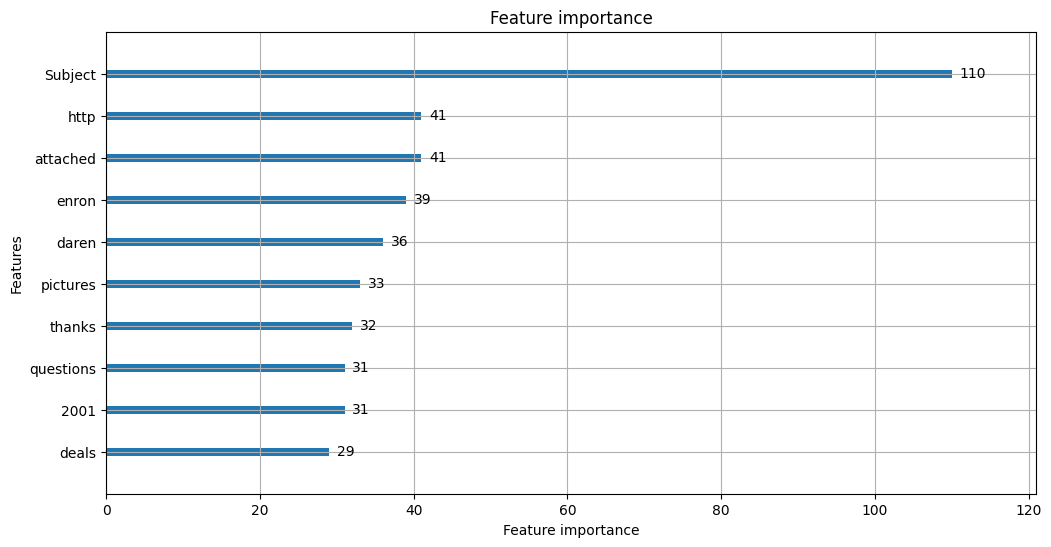

In [20]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, figsize=(12, 6), max_num_features=10)
plt.show()

In [21]:
spam_rows = (df.label == '1')
spam_data = df[spam_rows]

count = 0
for i in spam_data['text']:
    count = count + i.count('subject')

print(count)

160


In [22]:
legit_rows = (df.label == '0')
legit_data = df[legit_rows]

count = 0
for i in legit_data['text']:
    count = count + i.count('subject')

print(count)

2733
